## 引包

In [1]:
import os
import cv2
import io
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential, backend
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate, Lambda, Input, ZeroPadding2D, AveragePooling2D
from keras.utils.np_utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as widgets
from IPython.display import clear_output,display

#调用GPU方法
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)
# 选择编号为0的GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"#我的笔记本只有一块GPU，编号是0，所以这里调用编号为0的GPU


SEED=6
tf.random.set_seed(SEED)

2022-12-22 11:32:04.646924: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 11:32:05.426921: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22320 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:52:00.0, compute capability: 8.6


## 加载数据

In [2]:
x_train_savepath = '../../../../autodl-tmp/X_train.npy'
y_train_savepath = '../../../../autodl-tmp/Y_train.npy'
x_test_savepath = '../../../../autodl-tmp/X_test.npy'
y_test_savepath = '../../../../autodl-tmp/Y_test.npy'

def load_data():
    #如果数据集数组文件存在, 就直接载入
    if os.path.exists(x_train_savepath) and os.path.exists(y_train_savepath) and os.path.exists(
            x_test_savepath) and os.path.exists(y_test_savepath):
        X_train = np.load(x_train_savepath)
        Y_train = np.load(y_train_savepath)
        X_test = np.load(x_test_savepath)
        Y_test = np.load(y_test_savepath)
    return X_train, Y_train, X_test, Y_test


X_train, Y_train, X_test, Y_test = load_data()

In [3]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("Y_train:", Y_train.shape)
print("Y_test:", Y_test.shape)

X_train: (23040, 224, 224, 3)
X_test: (5760, 224, 224, 3)
Y_train: (23040, 3)
Y_test: (5760, 3)


## 搭建模型DenseNet121

In [4]:
denseNet121 = tf.keras.applications.densenet.DenseNet121(weights="imagenet",include_top=False,input_shape=(224,224,3))
model=denseNet121.output

model=tf.keras.layers.GlobalAveragePooling2D()(model)
model=tf.keras.layers.Dense(512,activation='relu')(model)
model=tf.keras.layers.Dropout(0.5)(model)
model=tf.keras.layers.Dense(3,activation="softmax")(model)
model=tf.keras.models.Model(inputs=denseNet121.input,outputs=model)

model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()

tensorboard = TensorBoard(log_dir="AD-CN-MCI-Original")
checkpoint = ModelCheckpoint("AD-CN-MCI-Original.h5", 
                            monitor='val_accuracy', 
                            mode = "auto", 
                            verbose = 1,
                            save_best_only =True)

2022-12-17 14:24:08.646046: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22320 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d5:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

2022-12-17 14:24:10.708390: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-17 14:24:10.708419: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-17 14:24:10.708463: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-12-17 14:24:10.708860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-17 14:24:10.856521: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-17 14:24:10.856924: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [5]:
reduce_LR = ReduceLROnPlateau(monitor="val_loss", 
                             factor = 0.5, 
                             patience = 2, 
                             min_delta=0.001, 
                             mode = "auto", 
                            verbose = 1)

In [6]:
history = model.fit(X_train, Y_train,
                  validation_split =0.1,
                  epochs =100, 
                  verbose =1, 
                  batch_size = 32, 
                  callbacks = [tensorboard, checkpoint, reduce_LR])

2022-12-17 14:24:16.879636: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12485394432 exceeds 10% of free system memory.
2022-12-17 14:24:28.152986: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12485394432 exceeds 10% of free system memory.
2022-12-17 14:24:37.439531: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-17 14:24:46.799829: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8400
2022-12-17 14:24:48.864430: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


  1/648 [..............................] - ETA: 2:13:41 - loss: 1.5222 - accuracy: 0.2188

2022-12-17 14:24:50.071209: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-17 14:24:50.071240: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/648 [..............................] - ETA: 12:02 - loss: 1.5978 - accuracy: 0.2812  

2022-12-17 14:24:50.979948: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-17 14:24:50.980765: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-17 14:24:51.030365: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2825 callback api events and 2837 activity events. 
2022-12-17 14:24:51.100473: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-17 14:24:51.166830: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: AD-CN-MCI-Original/train/plugins/profile/2022_12_17_14_24_51

2022-12-17 14:24:51.223336: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to AD-CN-MCI-Original/train/plugins/profile/2022_12_17_14_24_51/autodl-container-33ed11913c-1884a065.trace.json.gz
2022-12-17 14:24:51.304102: I tensorflow/core/profiler/rpc/client/sa

648/648 [==============================] - 87s 116ms/step - loss: 1.0374 - accuracy: 0.4665 - val_loss: 1.0899 - val_accuracy: 0.4523

Epoch 00001: val_accuracy improved from -inf to 0.45226, saving model to AD-CN-MCI-Original.h5
Epoch 2/100
648/648 [==============================] - 70s 108ms/step - loss: 0.9726 - accuracy: 0.5113 - val_loss: 1.0644 - val_accuracy: 0.4774

Epoch 00002: val_accuracy improved from 0.45226 to 0.47743, saving model to AD-CN-MCI-Original.h5
Epoch 3/100
648/648 [==============================] - 70s 108ms/step - loss: 0.9308 - accuracy: 0.5402 - val_loss: 1.6523 - val_accuracy: 0.3767

Epoch 00003: val_accuracy did not improve from 0.47743
Epoch 4/100
648/648 [==============================] - 70s 108ms/step - loss: 0.8877 - accuracy: 0.5612 - val_loss: 0.9373 - val_accuracy: 0.5556

Epoch 00004: val_accuracy improved from 0.47743 to 0.55556, saving model to AD-CN-MCI-Original.h5
Epoch 5/100
648/648 [==============================] - 71s 110ms/step - loss: 

In [7]:
def accuracy_lr_loss_plot (history):
    fig = plt.figure(figsize=(15,10))
    
    plt.subplot(221)
    plt.plot(history.history["loss"], "bo--", label="loss")
    plt.plot(history.history["val_loss"], "ro--", label = "val_loss")
    plt.title("Training Data Loss")
    plt.xlabel("Number of epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(222)
    plt.plot(history.history["accuracy"], 'bo--', label="accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
   
    
    plt.show()

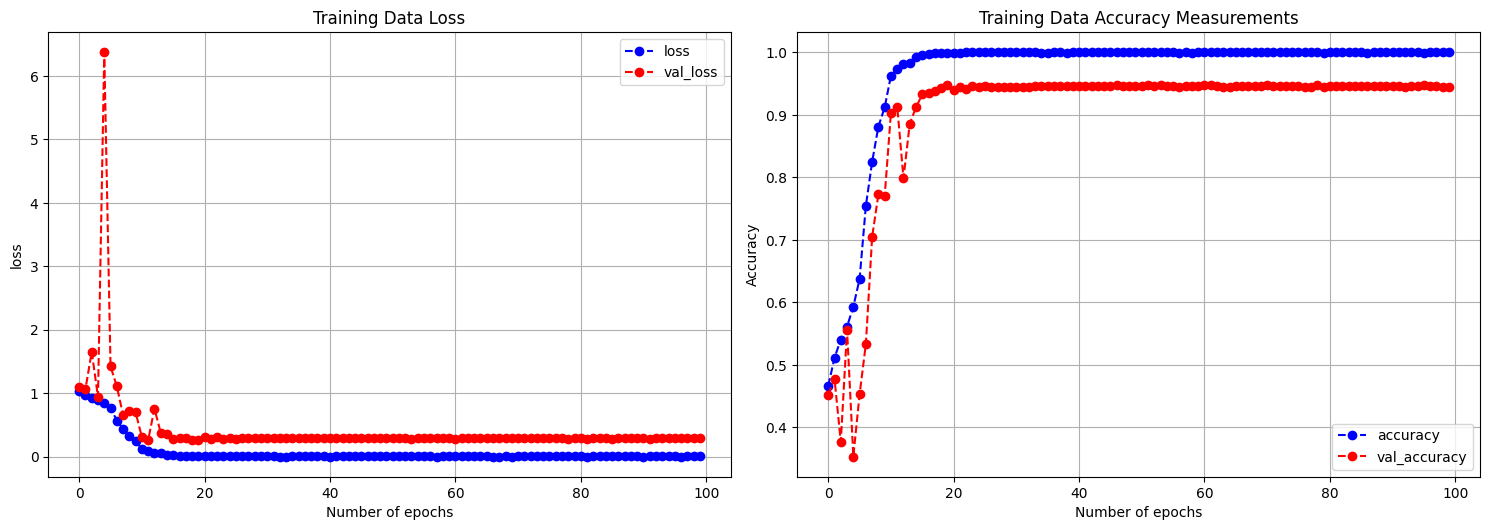

In [8]:
accuracy_lr_loss_plot(history)

In [12]:
result= model.evaluate(X_test,Y_test,batch_size=32)
print("Accuracy is\n",result)

# dataFrame = pd.DataFrame({"loss":result[0], "accuracy":result[1]}, index=[0])

# dataFrame.to_csv("AD-CN-Classification.csv", index=False, mode="a")

# dataFrame.to_csv("AD-CN-Classification.csv", index=False, mode="a", header=False)


180/180 [==============================] - 8s 32ms/step - loss: 0.2379 - accuracy: 0.9477
Accuracy is
 [0.2379290908575058, 0.9477430582046509]


### 绘制混淆矩阵及特异-敏感性分析

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

labels = ["AD", "CN", "MCI"]

y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test_new = np.argmax(Y_test, axis=1)
target_names = labels

2022-12-22 11:32:50.152551: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-22 11:32:53.628976: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8400
2022-12-22 11:32:55.910967: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [6]:
print(classification_report(y_test_new, y_pred,target_names=target_names))

              precision    recall  f1-score   support

          AD       0.97      0.93      0.95      1913
          CN       0.98      0.95      0.97      1891
         MCI       0.90      0.95      0.93      1956

    accuracy                           0.95      5760
   macro avg       0.95      0.95      0.95      5760
weighted avg       0.95      0.95      0.95      5760



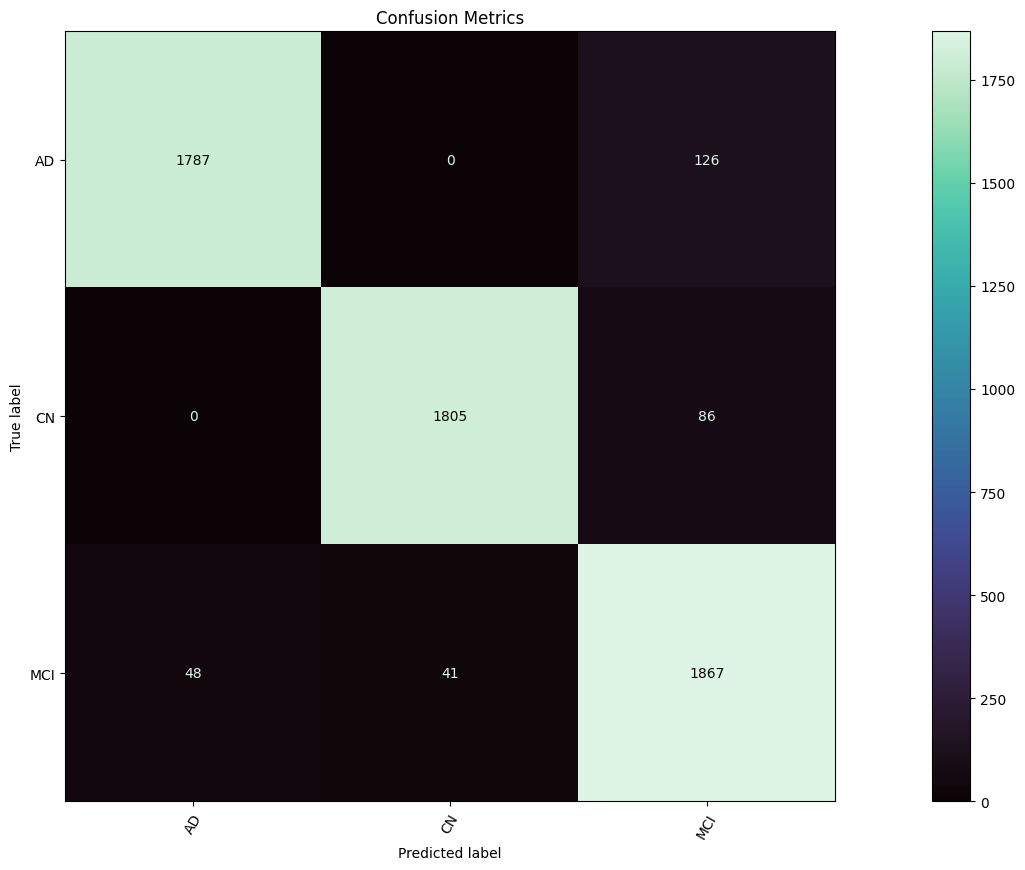

In [7]:
cm=confusion_matrix(y_test_new, y_pred)
display_c_m = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(25,10)) 
display_c_m.plot(cmap='mako',ax=ax,xticks_rotation=60)
plt.title("Confusion Metrics")
plt.show()

In [8]:
Sensitivity = cm[0][0] / (cm[0][0] + cm[0][1])
Specificity = cm[1][1] / (cm[1][0] + cm[1][1])
print("Sensitivity: " + str(Sensitivity))
print("Specificity: " + str(Specificity))

Sensitivity: 1.0
Specificity: 1.0


In [ ]:
# 在医学统计里，任何一个诊断指标，都有两个最基本的特征，即敏感性和特异性。
# 所谓敏感性，就是指其在诊断疾病的时候不漏诊的机会有多大，所谓特异性就是指该指标在诊断某疾病时，不误诊的机会有多大。
# 单独一个指标，如果提高其诊断的敏感性，必然降低其诊断的特异性，换句话说，减少漏诊必然增加误诊，反之亦然

In [9]:
from sklearn.metrics import precision_recall_fscore_support

res = []
for i in labels:
    prec, recall, _, _ = precision_recall_fscore_support(np.array(y_test_new)==1,
                                                         np.array(y_pred)==1,
                                                         pos_label=True, average=None)
    
    res.append([i, recall[0], recall[1]])

pd.DataFrame(res, columns = ["class", "sensitivity", "specificity"])

,class,sensitivity,specificity
0,AD,0.989403,0.954521
1,CN,0.989403,0.954521
2,MCI,0.989403,0.954521


In [10]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
acc = accuracy_score(y_test_new, y_pred)
pre = precision_score(y_test_new, y_pred, average='macro') 
recall = recall_score(y_test_new, y_pred, average='macro')

print("acc: " + str(acc))
print("pre: " + str(pre))
print("recall: " + str(recall))

acc: 0.9477430555555556
pre: 0.949886558566248
recall: 0.9477184204820613


### 保存训练的历史记录，方便以后再次画图

In [11]:
# 保存训练的历史记录pickle.dump()
import pickle

history_filename = "AD-CN-MCI-Original.json"
with open(history_filename, "wb") as file_json:
    pickle.dump(history.history, file_json)



NameError: name 'history' is not defined

In [ ]:
# 读取保存的训练历史记录
with open(history_filename, "rb") as file_json:
    history_file = pickle.load(file_json)

In [ ]:
def accuracy_lr_loss_plot_file (history_file):
    fig = plt.figure(figsize=(15,10))
    
    plt.subplot(221)
    plt.plot(history_file["loss"], "bo--", label="loss")
    plt.plot(history_file["val_loss"], "ro--", label = "val_loss")
    plt.title("Training Data Loss")
    plt.xlabel("Number of epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(222)
    plt.plot(history_file["accuracy"], 'bo--', label="accuracy")
    plt.plot(history_file['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
   
    
    plt.show()

In [ ]:
accuracy_lr_loss_plot_file(history_file)

In [4]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from  tensorflow.keras.models import load_model
import random
import glob

model = load_model("AD-CN-MCI-Original.h5")


2022-12-22 11:32:32.839967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22320 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:52:00.0, compute capability: 8.6
